# Regression model for task from Quantum

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [54]:
df_train = pd.read_csv("internship_train.csv")
df_test = pd.read_csv("internship_hidden_test.csv")

In [55]:
X = df_train.drop(columns = ['target'], inplace =  False)
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [56]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [57]:
pca = PCA(n_components = 5, random_state = 0)
  
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
  
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.03662791, 0.0195551 , 0.01941065, 0.01934091, 0.01925235])

Text(0.5, 1.0, 'PCA explained variance ratio')

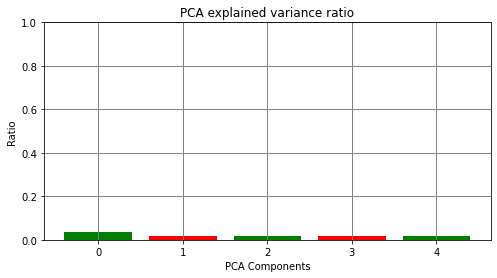

In [58]:
fig, ax = plt.subplots(figsize=(8,4))
x_ax = np.arange(len(explained_variance))
ax.bar(x_ax, explained_variance, color = ['g', 'r'])
ax.set_ybound((0,1))
ax.set_ylabel('Ratio')
ax.set_xlabel('PCA Components')
ax.grid(color='gray', linestyle='-', linewidth=1)
ax.set_title(label = "PCA explained variance ratio", loc = 'center')

<font color = 'red' size = 4>PCA is useless, 2 first components cant explain even 0.1 percent of varience(( </font>


<font size = 4>Let's use LASSO</font>

In [59]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
model = LassoCV(alphas= np.arange(0.1, 1, 0.01), cv=cv, n_jobs=-1)
model.fit(X_train, y_train)
print('Best alpha parameter: ' + str(model.alpha_))

Best alpha parameter: 0.9899999999999995


In [60]:
model = Lasso(alpha=0.99)
cv = RepeatedKFold(n_splits=15, n_repeats=3, random_state=0)
scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = abs(scores)
print('RMSE: ' + str(np.mean(scores)))

RMSE: 28.892533649536006


RMSE is to big, so let's use RandomForest


In [61]:
X_train_sc, X_val_sc, y_train, y_val = train_test_split(X_train_sc, y_train, test_size=0.25, random_state=0)

In [62]:
rfr = RandomForestRegressor(n_estimators = 30, max_features = 'sqrt', max_depth = 20, n_jobs = -1, random_state = 0)
rfr.fit(X_train_sc, y_train)

prediction_test = rfr.predict(X_test_sc)
prediction_val = rfr.predict(X_val_sc)

rmse_for_test = np.sqrt(mean_squared_error(y_test, prediction_test))
rmse_for_val = np.sqrt(mean_squared_error(y_val, prediction_val))

print(f"RMSE for test: {rmse_for_test}")
print(f"RMSE for validation set: {rmse_for_val}")



RMSE for test: 8.672323669529773
RMSE for validation set: 8.723751270304827


Depth and number of estimators are selected by hand, because of checking CV takes a lot of time for this specific data

In [63]:
pd.DataFrame(prediction_val).describe()

,0
count,18000.000000
mean,49.942682
std,22.113126
min,13.579683
25%,28.726192
50%,44.719726
75%,71.472585
max,90.605958


In [64]:
prediction = pd.DataFrame(rfr.predict(df_test))

In [65]:
prediction.to_csv('predictions.csv')